# Argon A-to-Z

This tutorial demonstrates a-to-z how to optimise Lennard Jones parameters for liquid argon, and without going into details. For details see other tutorials and wider MDMC documentation.

In [1]:
# Imports used for this tutorial
import numpy as np
import os
from MDMC.control import Control
from MDMC.MD import Atom, Dispersion, LennardJones, Simulation, Universe

Supported DL_POLY version 4.10


In [2]:
# Change the number of threads depending on the number of physical cores on your computer
# as it was tested for LAMMPS
os.environ["OMP_NUM_THREADS"] = "4"

In [3]:
# Build universe with density 0.0176 atoms per AA^-3
density = 0.0176
# This means cubic universe of side:
# 23.0668 A will contain 216 Ar atoms
# 26.911 A will contain 343 Ar atoms
# 30.7553 A will contain 512 Ar atoms
# 38.4441 A will contain 1000 Ar atoms
universe = Universe(dimensions=23.0668)
Ar = Atom('Ar', charge=0.)
# Calculating number of Ar atoms needed to obtain density
n_ar_atoms = int(density * np.product(universe.dimensions))
print(f'Number of argon atoms = {n_ar_atoms}')
universe.fill(Ar, num_struc_units=(n_ar_atoms))

Universe created with:
  Dimensions       [23.07, 23.07, 23.07]
  Force field                       None
  Number of atoms                      0

Number of argon atoms = 216


In the Jupyter cell above, a box of Argon atoms is set up. However, at this point there is no interaction forces between the argon atoms! In the cell below an appropriate (for argon) force-field interaction potential is defined.

In [4]:
Ar_dispersion = Dispersion(universe,
                           (Ar.atom_type, Ar.atom_type),
                           cutoff=8.,
                           function=LennardJones(epsilon=1.0243, sigma=3.36))

In this case the interaction potential chosen is the humble Lennard Jones (to get info see doc or type `help(LennardJones)`).

Also, a `cutoff` value is chosen (see `help(Dispersion)` for more info). A [rule of thumb for Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is to pick `cutoff=2.5*sigma`. The value for argon is recommended to be between 8 and 12 ang. `cutoff` is not a force-field parameter and therefore will not be refined. Ideally, and for any system you want to pick at value of the `cutoff` which is small while not compromising accuracy. For this system picking a value between 8 and 12 ang is found to give near identifical results.

Next (and before starting the refinement), we set up the MD engine and equilibrate the system. Note with MDMC the equilibration only needs to be done once. 

In [5]:
# MD Engine setup
simulation = Simulation(universe,
                        engine="lammps",
                        time_step=10.18893,
                        temperature=120.,
                        traj_step=15)

LAMMPS (29 Sep 2021 - Update 3)
  using 4 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper


LAMMPS (29 Sep 2021 - Update 3)
  using 4 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper
Total wall time: 0:00:00


Simulation created with lammps engine and settings:
  temperature  120.0



In [6]:
# Energy Minimization and equilibration
simulation.minimize(n_steps=5000)
simulation.run(n_steps=10000, equilibration=True)

OK; time to set up the actual refinement of the force-field parameters. 

First we need some data to refine against:

In [7]:
# exp_datasets is a list of dictionaries with one dictionary per experimental
# dataset
# Dataset from: van Well et al. (1985). Physical Review A, 31(5), 3391-3414
# resolution is None as the original author already accounted for instrument resolution
exp_datasets = [{'file_name':'data/Well_s_q_omega_Ar_data.xml',
                 'type':'SQw',
                 'reader':'xml_SQw',
                 'weight':1.,
                 'auto_scale':True,
                 'resolution':None}]

The number of `MD_steps` specified must be large enough to allow for successful calculation of all observables. This depends the `type` of the dataset provided and the value of the `traj_step` (specified when creating the `Simulation`). If a value for `MD_steps` is not provided, then the minimum number needed will be used automatically.

Additionally, some observables will have an upper limit on the number of MD_steps that can be used in calculating their dependent variable(s). In these cases, the number of `MD_steps` is rounded down to a multiple of this upper limit so that we only run steps that will be useful. For example, if we use 1000 `MD_steps` in calculation, but a value of 2500 is provided, then we will run 2000 steps and use this to calculate the variable twice, without wasting time performing an additional 500 steps.

In [8]:
fit_parameters = universe.parameters
fit_parameters['sigma'].constraints = [2.8,3.8]
fit_parameters['epsilon'].constraints = [0.6, 1.4]


control = Control(simulation=simulation,
                  exp_datasets=exp_datasets,
                  fit_parameters=fit_parameters,
                  minimizer_type="GPO",
                  reset_config=True,
                  MD_steps=2000, 
                  equilibration_steps=2000,
                  n_points=40)

Control created with:
- Attributes                              -
  Minimizer                             GPO
  FoM type               ChiSquaredExpError
  Number of observables                   1
  Number of parameters                    2



And finally start the refinement! Bump up `n_steps` from 3 when you are ready.

Step         FoM Change state  Pred coords     Pred FoM epsilon (#2)   sigma (#3)


   0       390.1     Accepted [1.0243 kJ / mol, 3.36 Ang]        390.1        1.024         3.36


   1         447     Accepted [1.0243 kJ / mol, 3.36 Ang]        390.1        1.035        3.532


   2       702.2     Accepted [1.0243 kJ / mol, 3.36 Ang]        390.1        1.075        2.905


   3       809.5     Accepted [1.0243 kJ / mol, 3.36 Ang]        390.1       0.9356        3.782


   4       460.7     Accepted [1.0243 kJ / mol, 3.36 Ang]        390.1        1.396         3.47


   5       585.5     Accepted [1.0243 kJ / mol, 3.36 Ang]        390.1       0.7189        2.876


   6       383.6     Accepted [0.9138747812813468 kJ / mol, 3.1980552945444853 Ang]        383.6       0.9139        3.198


   7       603.8     Accepted [0.9138747812813468 kJ / mol, 3.1980552945444853 Ang]        383.6       0.8076        3.693


   8         378     Accepted [0.614122557686236 kJ / mol, 3.270806558889923 Ang]          378       0.6141        3.271


   9        1113     Accepted [0.614122557686236 kJ / mol, 3.270806558889923 Ang]          378        1.174        2.812


  10       374.6     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6       0.9896        3.336


  11       650.6     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6        1.218        2.966


  12       471.8     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6        0.747        3.001


  13       415.9     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6       0.7752        3.566


  14       824.9     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6        1.141        3.713


  15       441.9     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6        0.665        3.619


  16       737.8     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6        1.354        3.098


  17       484.7     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6        1.304        3.223


  18         531     Accepted [0.9895694293165027 kJ / mol, 3.3361782337854944 Ang]        374.6        1.119        3.104


  19       347.9     Accepted [0.8776078615896807 kJ / mol, 3.440732924682126 Ang]        347.9       0.8776        3.441


  20       334.6     Accepted [0.8477786864218813 kJ / mol, 3.4441358926671155 Ang]        334.6       0.8478        3.444


  21       336.3     Accepted [0.8477786864218813 kJ / mol, 3.4441358926671155 Ang]        334.6       0.6007         3.46


  22       325.6     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6        0.692        3.404


  23       329.7     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.7189        3.442


  24       338.6     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.6019        3.377


  25       335.8     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.7426        3.372


  26       330.5     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.7135        3.422


  27       419.6     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.6026         3.14


  28       332.4     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.7276        3.471


  29       332.6     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.6534         3.42


  30       347.1     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.7425        3.417


  31       354.3     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6       0.6028        3.492


  32       329.7     Accepted [0.6919884032392166 kJ / mol, 3.404004826756701 Ang]        325.6        0.707        3.448


  33       320.1     Accepted [0.602501486610082 kJ / mol, 3.420882810833756 Ang]        320.1       0.6025        3.421


  34       318.5     Accepted [0.6078608157110581 kJ / mol, 3.425925499390842 Ang]        318.5       0.6079        3.426


  35       327.5     Accepted [0.6078608157110581 kJ / mol, 3.425925499390842 Ang]        318.5       0.6069        3.416


  36       343.9     Accepted [0.6078608157110581 kJ / mol, 3.425925499390842 Ang]        318.5       0.6009        3.422


  37       385.1     Accepted [0.6078608157110581 kJ / mol, 3.425925499390842 Ang]        318.5        1.395        3.341


  38       331.3     Accepted [0.6078608157110581 kJ / mol, 3.425925499390842 Ang]        318.5       0.6675        3.437


  39       321.7     Accepted [0.6078608157110581 kJ / mol, 3.425925499390842 Ang]        318.5       0.6017         3.41

The refinement has finished. 
 
Minimum measured point is: 
(0.6078608157110581 kJ / mol, 3.425925499390842 Ang) with an FoM of 318.5040089013431. 
 
Minimum point predicted is: 
(0.6078608157110581 kJ / mol, 3.425925499390842 Ang) for an FoM of 318.5040089013431.
 
 

Automatic Scale Factors
  data/Well_s_q_omega_Ar_data.xml  0.214479


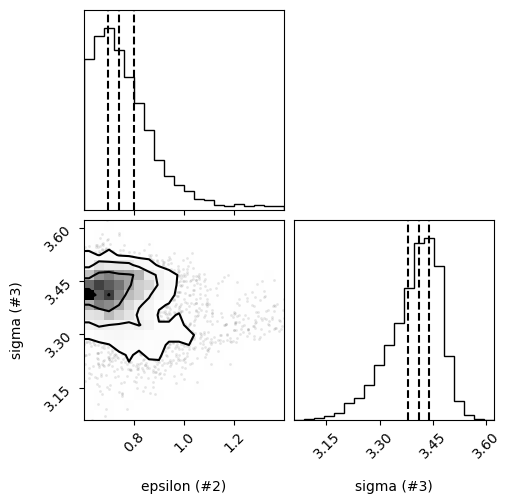

In [9]:
# Run the refinement, i.e. refine the FF parameters against the data
control.refine(n_steps=40)
control.plot_results();